In [1]:
import sys
sys.path.insert(0, './../Models')
from mlp_mixer import MLPMixer
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torchvision.datasets import CIFAR10
from torch.utils.data.dataloader import default_collate

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [3]:
def convert_keys(state_dict, map_classifier, num_classes = 10):
    keys = state_dict.keys()
    new_keys = []
    new_state_dict = {}

    for key in keys:
        new_key = key.replace("/", ".")
        new_key = new_key.replace("MixerBlock_", "MixerBlock.")
        new_key = new_key.replace("channel_mixing.Dense_0", "channel_mixing.1.net.0")
        new_key = new_key.replace("channel_mixing.Dense_1", "channel_mixing.1.net.3")
        new_key = new_key.replace("token_mixing.Dense_0", "token_mixing.2.net.0")
        new_key = new_key.replace("token_mixing.Dense_1", "token_mixing.2.net.3")
        new_key = new_key.replace("LayerNorm_0", "token_mixing.0")
        new_key = new_key.replace("LayerNorm_1", "channel_mixing.0")
        new_key = new_key.replace("scale", "weight")
        new_key = new_key.replace("kernel", "weight")
        new_key = new_key.replace("stem", "stem.0")
        new_key = new_key.replace("head", "head.0")
        new_key = new_key.replace("pre_head.0_layer_norm", "pre_head_layer_norm")
        new_keys.append(new_key)
    
    if map_classifier:
        for (key, new_key) in zip(keys, new_keys): 
            new_state_dict[new_key] = torch.tensor(state_dict[key], dtype = torch.float32).T
    else:
        for (key, new_key) in zip(keys, new_keys):
            weights = torch.tensor(state_dict[key], dtype = torch.float32).T
            if "head." in new_key:
                k = np.random.randint(0, weights.shape[0], num_classes)
                # For bias
                if len(weights.shape) == 1:
                    weights = weights[k]
                # For weights
                else:
                    weights = weights[k, :]
            new_state_dict[new_key] = weights
    return new_state_dict

In [4]:
# B/16 architecture
net = MLPMixer(in_channels = 3,
               dim = 768,
               num_classes = 10,
               patch_size = 16,
               image_size = 224,
               depth = 12,
               token_dim = 384,
               channel_dim = 3072).to(device)

google_weights = np.load("./../Weights/imagenet1k-Mixer-B_16.npz", allow_pickle = True)
new_weights = convert_keys(google_weights, map_classifier = False, num_classes = 10)

net.load_state_dict(new_weights, strict = False)

/tmp/ipykernel_310606/929378902.py:27: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  weights = torch.tensor(state_dict[key], dtype = torch.float32).T


<All keys matched successfully>

In [5]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

net.head = Identity()

In [6]:
data_dir = "./../Data"
batch_size = 32
shuffle = True

transform = T.Compose([
            T.Resize(224),
            T.ToTensor()])

train_dataset = CIFAR10(root = data_dir, train = True, transform = transform, download = True)
test_dataset = CIFAR10(root = data_dir, train = False, transform = transform, download = True)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = shuffle, 
                          collate_fn = lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = shuffle,
                          collate_fn = lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

Files already downloaded and verified
Files already downloaded and verified


In [7]:
outputs = torch.Tensor()
labels = torch.Tensor()

tqdm_loader = tqdm(train_loader, desc = "Inference Train Data", position = 0, leave = True)
for dat in tqdm_loader:
    image, label = dat[0], dat[1].cpu().detach()
    output = net(image).cpu().detach()
    outputs = torch.cat((outputs, output), dim = 0)
    labels = torch.cat((labels, label), dim = 0)
    tqdm_loader.update(1)
tqdm_loader.close()

tqdm_loader = tqdm(test_loader, desc = "Inference Test Data", position = 0, leave = True)
for dat in tqdm_loader:
    image, label = dat[0], dat[1].cpu().detach()
    output = net(image).cpu().detach()
    outputs = torch.cat((outputs, output), dim = 0)
    labels = torch.cat((labels, label), dim = 0)
    tqdm_loader.update(1)

Inference Test Data: 100%|██████████| 313/313 [01:01<00:00,  5.11it/s]


In [8]:
m = TSNE(n_components = 2, perplexity = 30, n_iter = 1000, learning_rate = 45)
features = m.fit_transform(outputs)

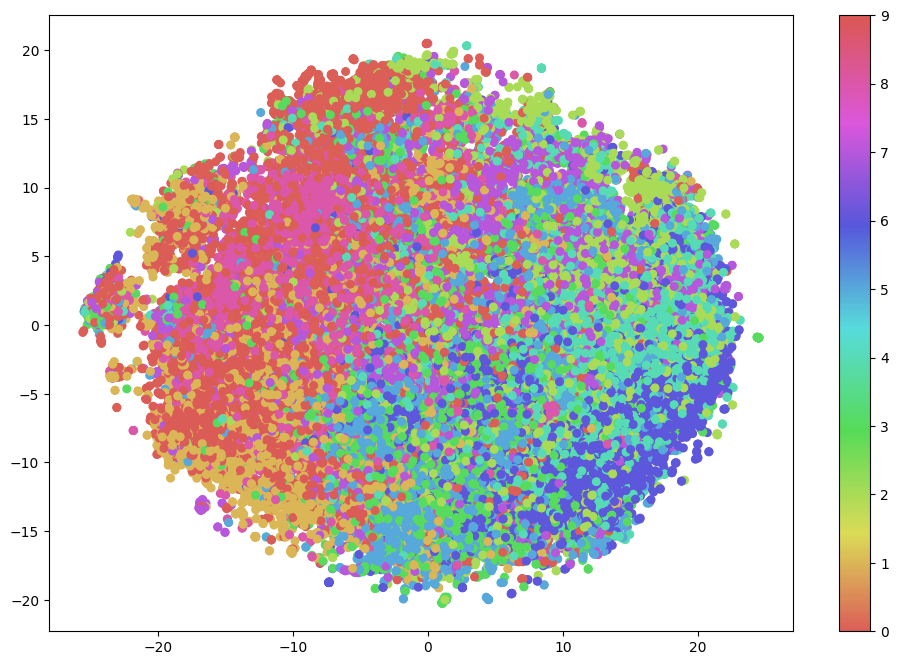

In [9]:
cmap = sns.hls_palette(as_cmap = True)
f, ax = plt.subplots(figsize = (12, 8))
points = ax.scatter(features[:, 0], features[:, 1], c = labels.numpy(), s = 30, cmap = cmap)
f.colorbar(points)
plt.savefig("./../Plots/CIFAR10_imagenet1kweights_TSNE.png")
plt.show()